In [1]:
# You can import *ANYTHING* you want here.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error # Requires sklearn 0.24 (December 2020), update with conda/pip if needed.
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

import pandas as pd

# Assignment 7: Tree methods

In this assignment we'll study tree methods and their capabilities as interpolators and extrapolators, and the importance of understanding your data. We will use a dataset of energy consumption of home appliances for houses in Chievres, Belgium. The data has the following variables:

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh (**Target variable**)energy_extrapolation
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), in C degrees

You are given two datasets: energy_appliances_standard.csv and energy_appliances_extrapolation.csv. The first dataset has typical consumption patterns, while the second one has the top 10% highest consumptions and will be used to test the extrapolating capacities of our models.


## Task 1: Random Forests (35/100)

Random Forests are excellent predictors. Usually we only need to tune one parameter: the number of trees in the model. However, how many trees are enough? Follow these steps:

1. Load the training dataset (energy_appliances_standard.csv) and show the descriptive statistics of the variables. (3 pts)

2. Create a train / test partition of the data using 30% of the data for the test set and a ```random_state``` value of 20201107(2 pts).

3. Follow [this example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) and train a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) using ```Appliances``` as the target variable. Test between 50 and 250 trees, plotting the Out-of-Bag (OOB) error after every iteration. Be patient as training can take a while. Written answer: What is the optimal number of trees for your model and why do you think this? (15 pts)

4. Train your final random forest with the number of trees you selected in part 3. Apply this model over your test set and over the extrapolating dataset (from the file ```energy_appliances_extrapolation.csv```), calculating the mean absolute percentual error for each dataset.  Show in a scatterplot the predicted value vs the real value of the target variable for both the test set and the extrapolation set (in the same plot), differentiating both by using different colors for the points. Written answer: How does the random forest model perform on predicting Appliance energy usage in the extrapolation data set? If it performs poorly, why? If it performs well, why? *Hint: look at the scatterplot*. (15 points)

In [2]:
# Data load
df = pd.read_csv('energy_appliances_standard.csv')
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,...,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000
mean,68.121229,3.445729,21.688855,40.150264,20.293891,40.469997,22.230926,39.160423,20.860319,38.983631,...,22.050534,43.016242,19.505556,41.552215,7.314032,755.566425,80.249079,3.969812,38.305214,3.762879
std,30.182146,7.552424,1.604312,3.930099,2.171999,4.063088,1.969945,3.219280,2.047586,4.320711,...,1.961083,5.202160,2.010550,4.161873,5.291010,7.339842,14.768037,2.447164,11.957900,4.187098
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,16.306667,29.600000,14.890000,29.166667,-5.000000,729.366667,24.000000,0.000000,1.000000,-6.600000
25%,50.000000,0.000000,20.760000,37.260000,18.790000,37.930000,20.790000,36.826667,19.566667,35.500000,...,20.828889,39.200000,18.066667,38.530000,3.500000,751.000000,71.333333,2.000000,29.000000,0.933333
50%,60.000000,0.000000,21.600000,39.533333,19.926667,40.545000,22.100000,38.466667,20.666667,38.363333,...,22.166667,42.440000,19.390000,40.863333,6.850000,756.100000,84.333333,3.500000,40.000000,3.433333
75%,80.000000,0.000000,22.600000,42.863333,21.463333,43.326667,23.290000,41.530000,22.100000,42.066667,...,23.390000,46.590000,20.600000,44.290000,10.333333,760.950000,91.845238,5.333333,40.000000,6.550000
max,190.000000,50.000000,26.200000,59.633333,29.856667,56.026667,29.100000,49.656667,26.200000,51.000000,...,27.230000,58.780000,24.500000,53.326667,26.100000,772.283333,100.000000,14.000000,66.000000,15.500000


In [3]:
# Create train / test split
df = pd.read_csv('energy_appliances_standard.csv')
y = df["Appliances"]
X =  df.drop("Appliances",axis=1)
RANDOM_STATE = 20201107
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = RANDOM_STATE)

In [4]:
# Define random forest and iterate over the number of trees
RFregressor = RandomForestRegressor(
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        )

min_estimators = 50
max_estimators = 250
error_rate = []
for i in range(min_estimators, max_estimators + 1, 5):
    RFregressor.set_params(n_estimators=i)
    RFregressor.fit(Xtrain, ytrain)

    oob_error = 1 - RFregressor.oob_score_
    error_rate.append((i, oob_error))

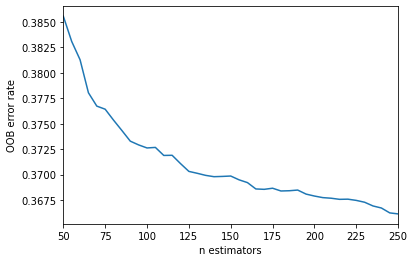

In [5]:
# Plot the OOB error per number of trees
# Generate the "OOB error rate" vs. "n_estimators" plot.

xs, ys = zip(*error_rate)
plt.plot(xs, ys)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n estimators")
plt.ylabel("OOB error rate")
plt.show()

**Written answer:** What is the optimal number of trees for your model and why do you think this? (15 pts)

The optimal number of number of trees is 250 since it has the mimimum OOB error.

In [6]:
# Final forest
ff = RandomForestRegressor(
            n_estimators = 250,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        )

ff.fit(Xtrain, ytrain)

# Calculate error over test set
y_pred = ff.predict(Xtest)
err_test = mean_absolute_percentage_error(y_pred, ytest)

# Load the second dataset
df_extrapolation = pd.read_csv('energy_appliances_extrapolation.csv')
y_extrapolation = df_extrapolation["Appliances"]
X_extrapolation =  df_extrapolation.drop("Appliances", axis=1)
# Calculate the error over it
y_pred_extrapolation = ff.predict(X_extrapolation)
err_extrapolation = mean_absolute_percentage_error(y_pred_extrapolation, y_extrapolation)

In [7]:
# Print MAPE over the sets
print("MAPE (test set): %f" % err_test)
print("MAPE (extrapolation set): %f" % err_extrapolation)

MAPE (test set): 0.179132
MAPE (extrapolation set): 2.923503


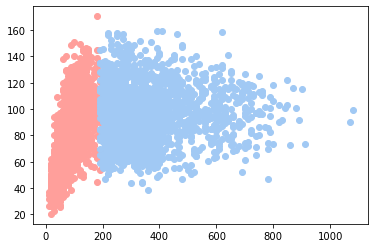

In [29]:
# Make the scatterplot
plt.scatter(ytest, y_pred, c = 'r')
plt.scatter(y_extrapolation, y_pred_extrapolation, c = 'b')

**Written answer:** How does the random forest model perform on predicting Appliance energy usage in the extrapolation data set? If it performs poorly, why? If it performs well, why? *Hint: look at the scatterplot*. (15 points)

The random forest model perform poorly on the extrapolation data set. I think this is because the extrapolation data set is much differ from the orginal dataset, and the target does not has that large values.


## Task 2: XGBoosting model (40 pts)

Now we'll repeat the process for the XGB model, using an [```XGBRegressor``` object](https://xgboost.readthedocs.io/en/latest/python/python_api.html). The XGBoosting model is much more sensitive to parameter changes though as it allows to tune many different parameters. For this example:

1. Written answer: Why do we say we want to use a small learning rate? Why do we say the number of trees to use depends on each dataset/problem? Why do we want to use a small tree depth? (6 pts)

2. Selecting a 30% validation sample over the training set, tune your parameters using crossvalidation. Use the following ranges:
 - Learning rate: [0.01, 0.1, 0.2].
 - max_depth: 3 to 7.
 - Number of trees: [350, 400, 450, 500]

Leave the other parameters at the values we identified in the lab (except for the objective parameter and those related to classification problems) and use a seed of 20201107. Report the optimal values of your parameters. (20 pts)

3. Repeat part 4 of the previous task, but now for your XGB model trained over the optimal parameter combination and the complete training dataset. Plot the variable importance. Written answer: What are the most important variables? Can the XGB model extrapolate? How does it compare to a random forest? (14 pts)

**Written answer part 1 (2 pts each):**


In [9]:
# Define the XGB model
XGB = XGBRegressor(
                    verbosity=1,                  # If to show more errors or not.
                    objective='reg:squarederror',       # Type of target variable.
                    booster='gbtree',             # What to boost. Trees in this case.
                    n_jobs=-1,                    # Parallel jobs to run. Set your processor number.
                    gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                    subsample=0.632,              # Subsample ratio. Can set lower
                    colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                    colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                    colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                    base_score=0.5,               # Global bias. Set to average of the target rate.
                    random_state=RANDOM_STATE        # Seed
                            )

In [10]:
# Define the parameter grid.
param_grid = dict({
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6 ,7],
    'n_estimators' : [350, 400, 450, 500]
                  })

In [11]:
df = pd.read_csv('energy_appliances_standard.csv')
EnergyTrain,  EnergyTest = train_test_split(df, test_size = 0.3, random_state = 20201107)

val_train = EnergyTrain.sample(frac = 0.6,               # The fraction to extract
                        random_state = RANDOM_STATE)    # The seed.

cv_object = StratifiedKFold(n_splits=2)

In [12]:
# Train grid search. This takes a while! Go grab a coffee.
GridXGB = GridSearchCV(XGB,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = cv_object,      # Cross-validation object.  
                       scoring = 'neg_mean_absolute_percentage_error', # How to rank outputs.
                       n_jobs = -1,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )
val_y = val_train['Appliances']
val_x = val_train.drop("Appliances",axis=1)

GridXGB.fit(val_x, val_y)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.001,
                                    gpu_id=None, grow_policy=None,
                                    importance_type=N...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=2020110

In [13]:
# Show best params
GridXGB.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 450}

In [14]:
df = pd.read_csv('energy_appliances_standard.csv')
y = df["Appliances"]
X =  df.drop("Appliances",axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = RANDOM_STATE)

XGB_opt = XGBRegressor(learning_rate = 0.1,  
                            max_depth =  7,
                            n_estimators = 450,
                            verbosity=1,                  # If to show more errors or not.
                            objective='reg:squarederror',       # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=-1,                    # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=RANDOM_STATE        # Seed
                            )


XGB_opt.fit(Xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.001, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=450, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=20201107, ...)

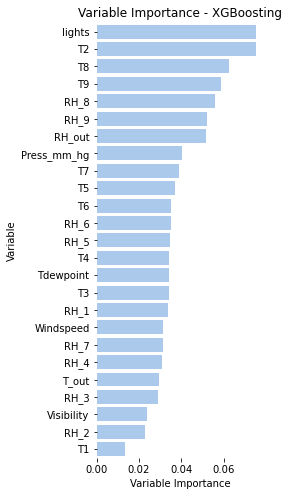

In [15]:
# Variable importance
importances = XGB_opt.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[Xtrain.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance")
sns.despine(left=True, bottom=True)

**Written answer:** Why do we say we want to use a small learning rate? Why do we say the number of trees to use depends on each dataset/problem? Why do we want to use a small tree depth?

Sicne XGBoosting model is much more sensitive to parameter, so we want to use a smaller learning rate can. The boosted tree model is constructed, sequentially where each new tree attempts to model and correct for the errors made by the sequence of previous trees. The small tree depth can reduce overfitting

In [16]:
y_pred_xgb = XGB_opt.predict(Xtest)
err_test_xgb = mean_absolute_percentage_error(y_pred_xgb, ytest)

# Calculate the error over it
y_pred_extrapolation_xgb = XGB_opt.predict(X_extrapolation)
err_extrapolation_xgb = mean_absolute_percentage_error(y_pred_extrapolation_xgb, y_extrapolation)

# Print MAPE over the sets
print("MAPE (test set): %f" % err_test_xgb)
print("MAPE (extrapolation set): %f" % err_extrapolation_xgb)

MAPE (test set): 0.179226
MAPE (extrapolation set): 2.835186


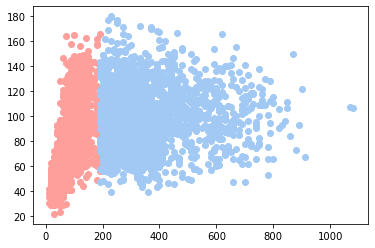

In [30]:
# Make the scatterplot
plt.scatter(ytest, y_pred_xgb, c = 'r')
plt.scatter(y_extrapolation, y_pred_extrapolation_xgb, c = 'b')

**Written answer:**  What are the most important variables? Can the XGB model extrapolate? How does it compare to a random forest? (14 pts)

The most important variables is light, XGB model cannot extrapolate. It performs slightly better than random forest.

## Task 3: Combined model (25 pts)

Now we will finally train a model on the combined data, by joining the extrapolation and the original dataset, and study the performance over the original test set, the new test set and the combined result. For this we will only use the Random Forest model. Use a seed of 20201107 for all functions that accept one.

1. Create a train / test split set over the extrapolation data, leaving approximately 30% of the data for testing purposes. Combine this train test with the original train set (let's call this the combined train set). (5 pts)
2. Train a Random Forest model over the **combined** train data. Discuss how many trees you used and why. (15 pts)
3. Plot the variable importance and compare it versus the XGB in task 1. Now that you more data, does the importance change? (5 pts)
3. Report the test set performance of your new model over the original test set, the test set you took over the extrapolation dataset and the combined test set. Plot the scatterplot of the both datasets as before in the same plot, differentiating the dataset by using colours. (10 pts)

Written answer: What happens now? What can you say about the new model?

In [18]:
# Create the new train and test set.
df1 = pd.read_csv('energy_appliances_standard.csv')
df2 = pd.read_csv('energy_appliances_extrapolation.csv')
df_combined = pd.concat([df1, df2])

yCombined = df_combined['Appliances']
XCombined = df_combined.drop("Appliances",axis=1)

XtrainCombined, XtestCombined, ytrainCombined, ytestCombined = train_test_split(XCombined,yCombined, test_size = 0.3, random_state = RANDOM_STATE)

In [21]:
# Obtain the new random forest (tune the trees)
RFregressor_2 = RandomForestRegressor(
            n_estimators = 250,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        )

RFregressor_2.fit(XtrainCombined, ytrainCombined)

RandomForestRegressor(max_features=None, n_estimators=250, oob_score=True,
                      random_state=20201107)

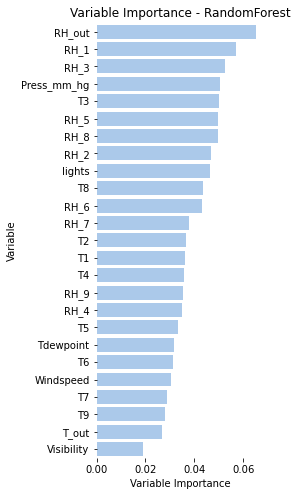

In [22]:
# Variable importance
importances = RFregressor_2.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - RandomForest")
sns.set_color_codes("pastel")
sns.barplot(y=[Xtrain.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance")
sns.despine(left=True, bottom=True)

**Written answer:** Train a Random Forest model over the **combined** train data. Discuss how many trees you used and why. (15 pts)

I will also use 250 trees since too large will lead to overfitting

In [23]:
# Print MAPE over the test sets
y_pred_RF_2 = RFregressor_2.predict(XtestCombined)
err_test_RF_2 = mean_absolute_percentage_error(y_pred_RF_2, ytestCombined)

# Print MAPE over the sets
print("MAPE (test set): %f" % err_test_RF_2)

MAPE (test set): 0.276045


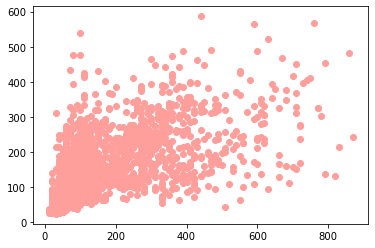

In [31]:
# Scatterplot
plt.scatter(ytestCombined, y_pred_RF_2, c = 'r')

**Written answer:** What happens now? What can you say about the new model?

The model perform better than before, it can fit both standard data and extrapolation data.